# Mise a la masse experiment

Here, we deomstrate setting up a 3D mise-a-la-masse experiment. A point electrode is connected to a conductive target at depth and potential measurements are taken on the surface

In [1]:
import numpy as np
from SimPEG import Mesh, Maps, Utils
from SimPEG.EM.Static import DC

try: 
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    print("Using LU solver. Will Be slow")

import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

## Mesh

In [2]:
cs = 10. 
core = 600. 
npad = 16
ncore = np.ceil(core/cs)

hx = Utils.meshTensor([(cs, npad, -1.3), (cs, ncore), (cs, npad, 1.3)])
hz = Utils.meshTensor([(cs, npad, -1.3), (cs, ncore)])

mesh = Mesh.TensorMesh([hx, hx, hz], x0=-np.r_[hx.sum()/2, hx.sum()/2, hz.sum()])

643264


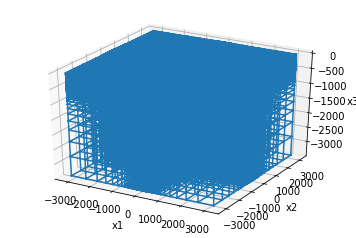

In [3]:
mesh.plotGrid()
print(mesh.nC)

## Conductivity Model

In [4]:
sigma_background = 1e-5
sigma_target = 1e-1

sigma = np.ones(mesh.nC)*sigma_background

In [5]:
target_thickness = 30. 
target_width = 100.
target_length = 200. 
target_center = -450.
target_dip = -80. 

In [6]:
# find the coordinates of the top and bottom of the place
dz = 0.5 * target_length * np.sin(np.deg2rad(target_dip))
dx = 0.5 * target_length * np.cos(np.deg2rad(target_dip))

In [7]:
target_line = lambda x: np.tan(np.deg2rad(target_dip)) * x + target_center

In [8]:
target_right = target_line(mesh.gridCC[:,0] - target_thickness/2.)
target_left = target_line(mesh.gridCC[:,0] + target_thickness/2.)
target_top = target_center - dz 
target_bottom = target_center + dz 

target_inds = (
    (mesh.gridCC[:, 2] <= target_right) & (mesh.gridCC[:, 2] >= target_left) &
    (mesh.gridCC[:, 1] >= -target_width/2.) & (mesh.gridCC[:, 1] <= target_width/2.) &
    (mesh.gridCC[:, 2] <= target_top) & (mesh.gridCC[:, 2] >= target_bottom)
)

In [9]:
sigma[target_inds] = sigma_target

In [10]:
import ipywidgets

In [11]:
def plot_model(i=mesh.vnC[1]/2):
    i = int(i) 
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(mesh.plotSlice(np.log10(sigma), normal='Y', ax=ax, ind=i)[0], ax=ax)
    ax.set_xlim([-250, 250])
    ax.set_ylim([-800, 0])    

In [12]:
ipywidgets.interact(
    plot_model,
    i = ipywidgets.IntSlider(min=0, max=mesh.vnC[1], value= int(mesh.vnC[1]/2.))
)

interactive(children=(IntSlider(value=46, description='i', max=92), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_model>

In [13]:
src_a = np.r_[0., 0., target_center]
src_b = np.r_[0., 1500., -cs/2. ]

(-800, 0)

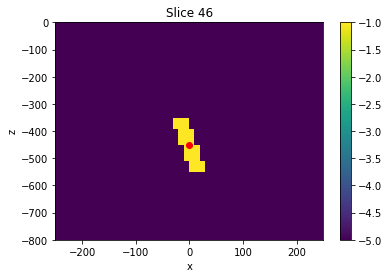

In [14]:
fig, ax = plt.subplots(1,1)
plt.colorbar(mesh.plotSlice(np.log10(sigma), normal='Y', ax=ax)[0], ax=ax)
ax.plot(src_a[0], src_a[2], 'ro')
ax.set_xlim([-250, 250])
ax.set_ylim([-800, 0])

## Survey parameters

Specify the receiver locations

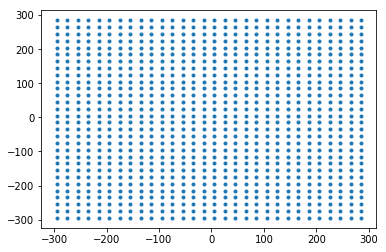

In [15]:
rx_x = mesh.vectorCCx[(mesh.vectorCCx >= -300) & (mesh.vectorCCx <= 300)][::2]
rx_y = mesh.vectorCCy[(mesh.vectorCCy >= -300) & (mesh.vectorCCy <= 300)][::2] 
rx_z = np.r_[mesh.vectorCCz.max()]

rx_locs = Utils.ndgrid([rx_x, rx_y, rx_z])
plt.plot(rx_locs[:,0], rx_locs[:,1], '.')

In [16]:
rx = DC.Rx.Pole(rx_locs)
src = DC.Src.Dipole([rx], src_a, src_b)
survey = DC.Survey([src])

In [17]:
prob = DC.Problem3D_CC(mesh, sigmaMap=Maps.IdentityMap(mesh), Solver=Solver)
prob.pair(survey)

## Compute Data

In [18]:
%%time
dpred = survey.dpred(sigma)

CPU times: user 6min 30s, sys: 12.9 s, total: 6min 43s
Wall time: 4min 10s


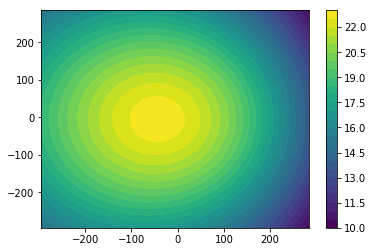

In [20]:
plt.colorbar(
    plt.contourf(
        rx_x, rx_y, 
        dpred.reshape(len(rx_x), len(rx_y), order='F'), 30,
    ), 
)